# Progress Report and Documentation


What I have been working on. 
1. Updating Docker-stacks dockerfile build instructions in order to make a HPC ready Dockerbuild.
2. Updating the aforementioned stack, in order to perform regular maintance and to fix build problems due to 
updates of upstream software sources.
3. Debugging and visualisation of the BluePyOpt GA algorithm.


## Other work
1.  The people at BluePyOpt (Werner) agreed to make a scidash branch, they want me to make use extensibility and inheritence. Such that my scidash derivation of BluePyOpt inherits from and extends as much as possible the parent class of their elitist branch at BPO.


## Resolving Docker Build issues. 

* Issue 1 Upgrading pip to pip10, breaks NU installation.
Work around: re-write setup.py to exclude problems associated with process dependency links.

    
* Issue 2   
Developing in BPO and NU simultaneously requires a dockerfile at to build from a location at one location down in the directory hierarchy: There is a need to install both packages using the pip -e paradigm (file changes during session at developer locations, effect modules that are in sys.path):
** ADD neuronunit neuronunit
** ADD BluePyOpt BluePyOpt
To this end scidash opt was created.
https://github.com/russelljjarvis/scidashopt


# New issue:
Dask bag syntax changed to be more concise, this was discovered because of regular docker rebuilding of the project. This has been recently updated, and the changes have been commited.


## What works 

Plotting of candidate solutions in 2D error surface slices, and using this as a means to validate GA candidate solutions, see below.

Presenting tabular data as pandas Data frames. see below.



## What does not yet work
The mean errors of the Genetic Algorithm have a downward trend, but they do not reliably decrease like the gradient descent alogorithm.
in order to circumvent this percieved flaw, two interventions have been used.


https://github.com/russelljjarvis/neuronunit/blob/dev/neuronunit/unit_test/pipe_entry_point.py#L86

lines 152-154 have 
https://github.com/russelljjarvis/BluePyOpt/blob/elitism/bluepyopt/deapext/algorithms.py#L155-156
Line 152-154 of BluePyOpt/bluepyopt/deapext/algorithms.py

have been put in, to enforce that genes that have been selected to be parents for breeding are fitter than the on average than the rest of the population of genes. I believe that the usage of this particular assert clause, will help to further isolate the cause of instabliity in fitness evolution.

Furthermore, I have created methods for plotting the Hall of Fame and it's evolution as a means to corroborate GA results.


## Other problems
* Dropbox sync causes file reaad write problems during simulations over prolonged durations.
This can be circumvented by momentarily pausing syncing.

* This motivated me to stop convenient, but lazy reading and writing of attributes from disk, which could otherwise be stored
in the Data Transport Container. 
* I updated the file models/backends/neuron.py in two crucial places.



## What will work with more time

Grid Search on HPC over docker seems to mostly work.

A docker container was made especially to run on a Spike server administratored by Renate. To this end, I have created a dedicated [branch](https://github.com/russelljjarvis/docker-stacks-returned/tree/hpc), with a different entrypoint. 
The docker container builds The container has an entrypoint which runs an exhaustive search simulation. 


## The command: 
```
nohup docker run -v /home/rjarvis/git/neuronunit:/home/jovyan/neuronunit scidash/neuronunit-optimization```
is sufficient to run the file
```/home/rjarvis/git/neuronunit/neuronunit/unit_test/grid_entry_point.py``` with python.

On the neurospike server many core are available ~50 I have used 36 in dask bags function 
`db.from_sequence(items,npartitions = 36)`. This occurs in two places in the exhaustive (grid) search algorithm. In the find rheobase algorithm, and the neuronounit score algorithm. 

Once the NU algorithm has run, files from the spike server are aggregated in a directory accessible to this script, using the command:

```alias cnspike='cd /Users/rjjarvis/Dropbox\ \(ASU\)/capsule/neuronunit/neuronunit/unit_test/grid_server; scp -P 2200 rjarvis@129.219.30.18:/home/rjarvis/git/neuronunit/neuronunit/unit_test/*.p .'```


Previously when running this file, it ran without error, however, because I forgot to mount a volume, pickle files generated in this session where not stored. I have since executed the command using a mounted volume, and I am now waiting for an output from the command.

It is expected that this will write four different files, with the prefix=grid_cell, and suffix=neurolex ID
At the location neuronunit/neuronunit/unit_test on the spike server.


This file runs without error
As confirmed by running 
```tail $HOME/nohup.out```, on the spike server, however the expected pickle files are not present there.

I expect this is because on the first run, I failed to define a mount point, to mount a volume in the docker run command, such that results would write to a location on the HOST OS upon exiting. 


In [1]:
import pickle
with open('dump_all_cells','rb') as f:
   pipe_results = pickle.load(f)

len(pipe_results['100201']['gen_vs_hof'])
pipe_results['100201']['gen_vs_hof'][-3].fitness.values


(0.9851880961358923,
 0.9999998460495455,
 0.1113894226364226,
 0.9778061659155625,
 0.951126989040242,
 0.08067550892522224,
 0.1865624876789671)


# Assumptions about this code:
The NB was launched with a command that mounts two volumes inside a docker container. 
In the future invocation of this script will be simplified greatly. NU is from a specific fork and branch -b results https://github.com/russelljjarvis/neuronunit 
BluePyOpt is also from a specific fork and branch: -b elitism https://github.com/russelljjarvis/BluePyOpt

Below BASH code for Ubuntu host:

``` bash
cd ~/git/neuronunit; sudo docker run -it -v `pwd`:/home/jovyan/neuronunit -v ~/git/BluePyOpt:/home/jovyan/BluePyOpt neuronunit-optimization /bin/bash'
```

## Parallel Environment.
Parallelisation module: dask distributed.

In [2]:
import os
os.system('jupyter trust test_ga_versus_grid.ipynb'); #suppress the untrusted notebook warning.
import deap


In [3]:
import pandas as pd
cell_names = list(pipe_results.keys())
param_names = list(pipe_results[list(pipe_results.keys())[0]]['pop'][0].dtc.attrs.keys())
df = pd.DataFrame(index=pipe_results.keys(),columns=param_names)

In [4]:
import pandas as pd
for index, val in enumerate(pipe_results.values()):
    if index == 0:
        sci = pd.DataFrame(list(val['pop'][0].dtc.scores.values())).T
    else:    
        sci = sci.append(pd.DataFrame(list(val['pop'][0].dtc.scores.values())).T)
        
sci

,0,1,2,3,4,5,6
0,0.287557,0.995273,0.925999,0.949164,0.353671,0.649446,0.829429
0,0.977367,0.999998,0.002095,0.988204,0.761606,0.275576,0.075223
0,0.977367,0.999998,0.002095,0.988204,0.761606,0.275576,0.075223


In [5]:
import pandas as pd
for index, val in enumerate(pipe_results.values()):
    if index == 0:
        attrs = pd.DataFrame(list(val['pop'][0].dtc.attrs.values())).T
    else:    
        attrs = attrs.append(pd.DataFrame(list(val['pop'][0].dtc.attrs.values())).T)
        
attrs.columns = val['pop'][0].dtc.attrs.keys()    
#print(attrs)
attrs

,k,v0,b,a,vpeak,d,vr,C,vt,c
0,0.000642,-49.576988,-3.090563e-09,0.130535,32.119282,0.112518,-55.491363,0.000098,-48.623697,-59.858263
0,0.000649,-69.280158,-4.766151e-09,0.360238,33.616100,0.147193,-74.349709,0.000093,-41.785351,-57.520939
0,0.000649,-69.280158,-4.766151e-09,0.360238,33.616100,0.147193,-74.349709,0.000093,-41.785351,-57.520939


In [6]:
import pandas as pd


for index, val in enumerate(pipe_results.values()):
    if index == 0:
        #,columns=['Dice number','value'],index=[1,2,3,4])
        rheobase = pd.DataFrame([i.dtc.rheobase for i in val['pop']]).T
    else:    
        rheobase = rheobase.append(pd.DataFrame([i.dtc.rheobase for i in val['pop']]).T)
        
rheobase

names = [ str('generation: ')+str(i) for i in range(0,len(rheobase)) ]

rheobase


,0,1,2,3,4,5,6,7
value,9.114583333333332 pA,21.158854166666664 pA,500.0 pA,208.33333333333331 pA,12.369791666666666 pA,11.71875 pA,205.078125 pA,500.0 pA
value,173.17708333333331 pA,452.63671875 pA,271.484375 pA,203.125 pA,177.08333333333331 pA,462.40234375 pA,259.27734375 pA,207.03125 pA
value,173.17708333333331 pA,452.63671875 pA,271.484375 pA,203.125 pA,177.08333333333331 pA,462.40234375 pA,259.27734375 pA,207.03125 pA


In [7]:
import matplotlib
%matplotlib inline


################
# GA parameters:
about $10^{3}=30$ models will be made, excluding rheobase search.
################


# Choice of selection criteria is important. 
Here we use BluepyOpts IBEA, such that it can be compared to NSGA2.

https://link.springer.com/article/10.1007/s00500-005-0027-5




In [8]:
MU = 6; NGEN = 6; CXPB = 0.9
USE_CACHED_GA = False

################
# Grid search parameters:
$ 2^{10}=1024 $ models, will be made excluding rheobase search
################

An oppurtunity to improve grid search, by increasing resolution of search intervals given a first pass:

In [9]:
from neuronunit.plottools import plot_surface


# Below two error surface slices from the hypervolume are plotted.
The data that is plotted consists of the error as experienced by the GA.
Note: the GA performs an incomplete, and efficient sampling of the parameter space, and therefore sample points are irregularly spaced. Polygon interpolation is used to visualize error gradients. Existing plotting code from the package BluePyOpt has been extended for this purpose.
Light blue dots indicate local minima's of error experienced by the NSGA algrorithm.


Mostly these plots show that a low error solution was found in each 2D plane, however occasionally the plots show, that a non optimal solution was arrived at.

<Figure size 432x288 with 0 Axes>

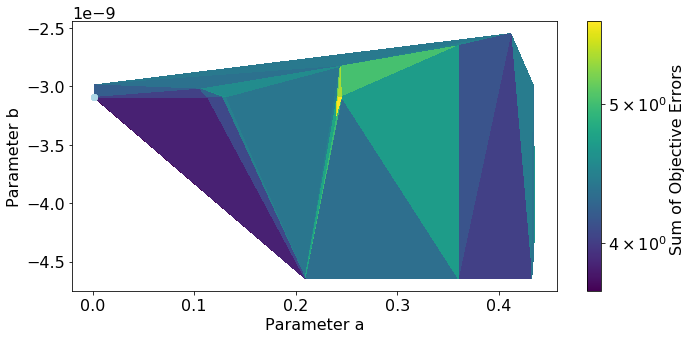

<Figure size 432x288 with 0 Axes>

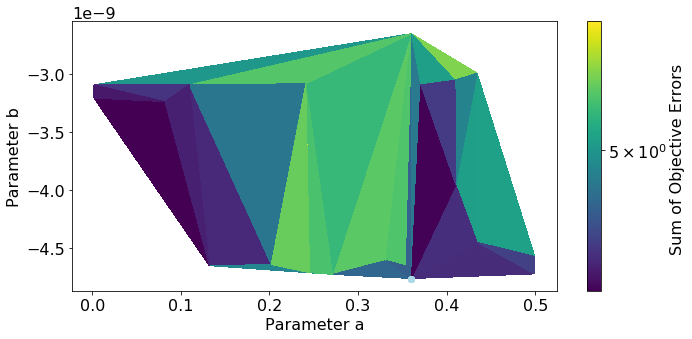

<Figure size 432x288 with 0 Axes>

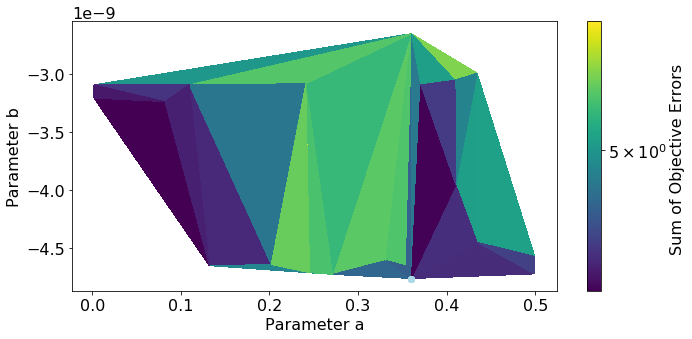

In [10]:
for index, val in enumerate(pipe_results.values()):
    td = val['td_py']
    history = val['history']

    plot_surface('a','b',td,history)

<Figure size 432x288 with 0 Axes>

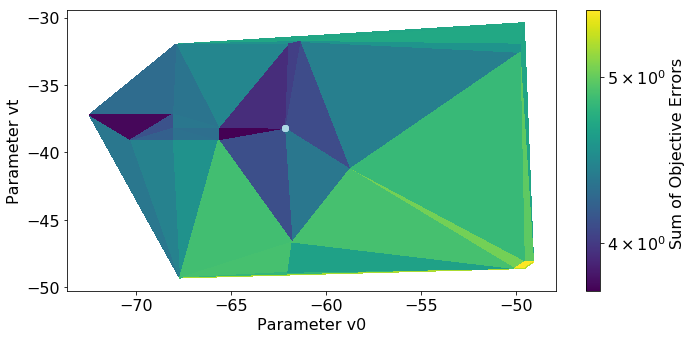

<Figure size 432x288 with 0 Axes>

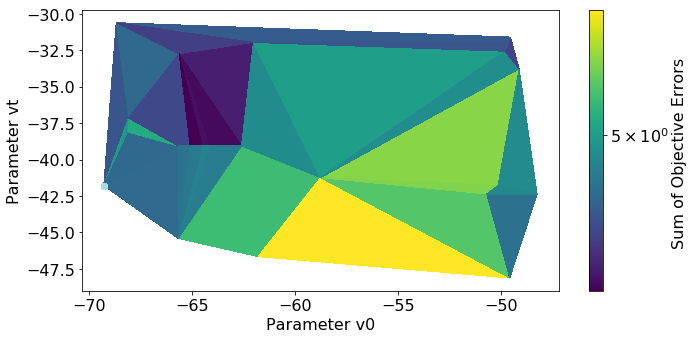

<Figure size 432x288 with 0 Axes>

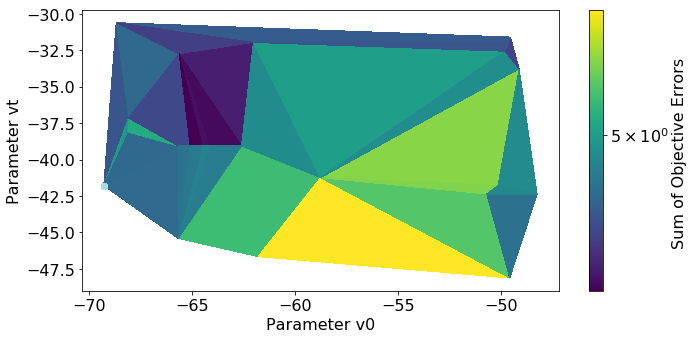

In [11]:

for index, val in enumerate(pipe_results.values()):
    td = val['td_py']
    history = val['history']

    plot_surface('v0','vt',td,history)
    

In [12]:
list(pipe_results.keys())
for k in pipe_results.keys():
    print(pipe_results[k]['hranked'])
pipe_results['100201']['hranked']

[4.3226437302864404, 4.12943439258374, 3.8038539556713955, 3.8038539556713955]
[5.14330082773465, 4.348633241118298, 4.292748516381854, 4.292748516381854]
[5.14330082773465, 4.348633241118298, 4.292748516381854, 4.292748516381854]


[5.14330082773465, 4.348633241118298, 4.292748516381854, 4.292748516381854]

I am currently writing code that should enable the plotting of HOF values versus generation.

In [13]:

dtcs = list(filter(lambda d: hasattr(d,'dtc'), pipe_results['100201']['hranked']))
dtcs = [d.dtc for d in dtcs ]
fitness = list(filter(lambda f: hasattr(f,'fitness'), pipe_results['100201']['hranked']))
fit_v_gen = [np.sum(f.fitness.values) for f in fitness ]

fit_v_gen



[]

dict_keys(['nifext_50', '100201', 'nifext_120'])
[]
[0, 1, 2, 3, 4, 5]
6 6


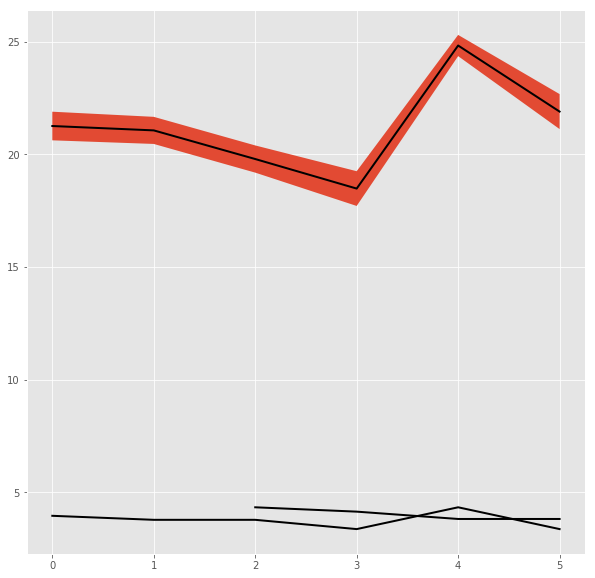

In [23]:


print(pipe_results.keys())

scores = list(filter(lambda dtc: hasattr(dtc,'score'), dtcs))

print(scores)
import pickle
with open('dump_all_cells','rb') as f:
   pipe_results = pickle.load(f)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
fig, axes = plt.subplots(figsize=(10, 10), facecolor='white')
val = list(pipe_results.values())[0]
log = val['log']
gen_numbers = [ i for i in range(0,len(log.select('gen'))) ]
print(gen_numbers)


hof = val['hof_py']
mean = np.array([ np.sum(np.square(i)) for i in log.select('avg')])
std = np.array([ np.sqrt(np.mean(np.square(i))) for i in log.select('std')])
minimum = np.array([ np.sqrt(np.mean(np.square(i))) for i in log.select('min')])
best_line = [None,None]
best_line +=val['hranked']
print(len(best_line),len(minimum))
#blg = [ best_line[h] for i, h in enumerate(gen_numbers) ]

stdminus = mean - std
stdplus = mean + std

axes.plot(
    gen_numbers,
    mean,
    color='black',
    linewidth=2,
    label='population average')


axes.plot(
    gen_numbers,
    best_line,
    color='black',
    linewidth=2,
    label='population average')




axes.plot(
    gen_numbers,
    minimum,
    color='black',
    linewidth=2,
    label='population minimum')
axes.fill_between(gen_numbers, stdminus, stdplus)
    
   

For some reason the global minimum solution is not converged on, as shown by the evolution of errors below:

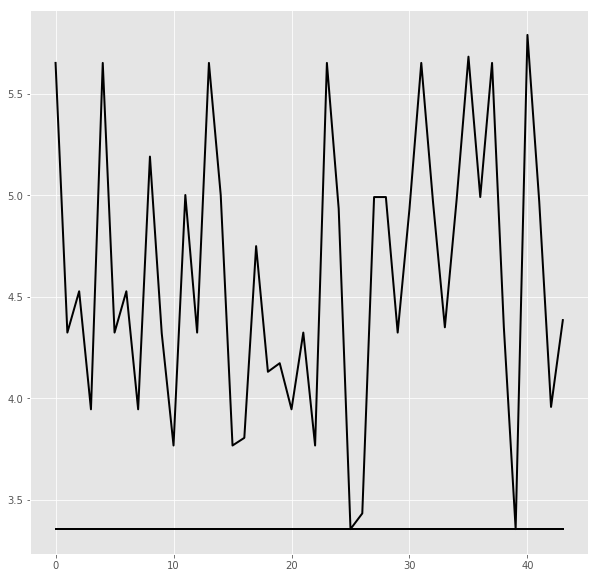

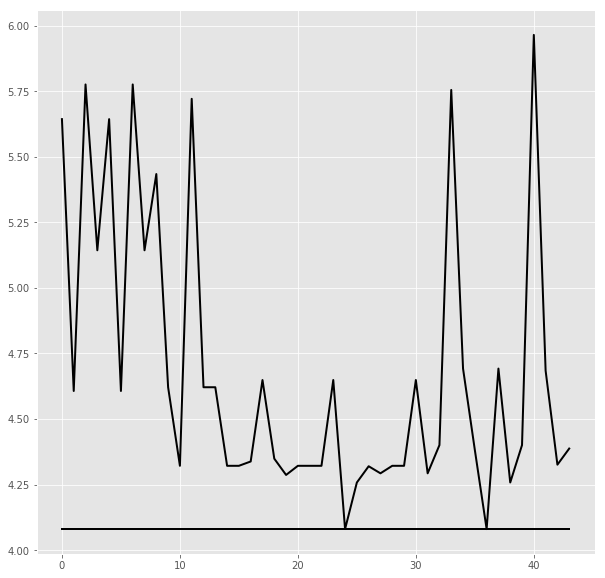

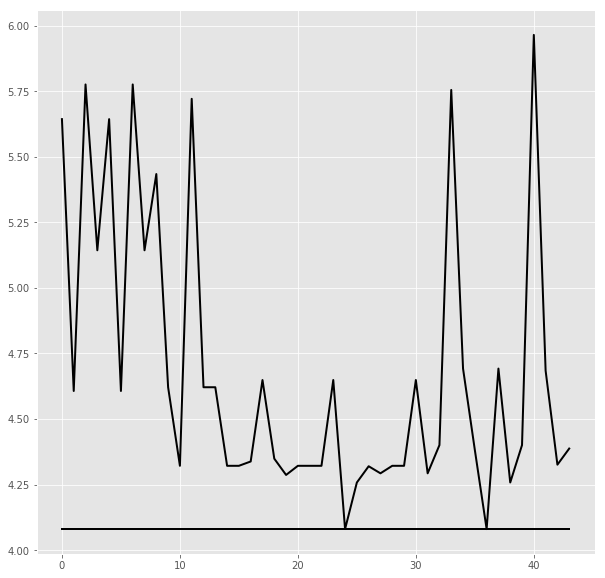

In [15]:

best_line = None
 
for k in pipe_results.keys():
    fig, axes = plt.subplots(figsize=(10, 10), facecolor='white')

    historiesc = [list(h.dtc.scores.values()) for h in pipe_results[k]['history'].genealogy_history.values() ]

    historiest = [(sum(h.dtc.scores.values()),h.dtc) for h in pipe_results[k]['history'].genealogy_history.values() ]
    ranked = sorted(historiest, key=lambda w: w[0],reverse = True) 
    pipe_results[k]['abs_min'] = ranked[0][1]
    
    historiess = [sum(h.dtc.scores.values()) for h in pipe_results[k]['history'].genealogy_history.values() ]
    min_line = np.min(historiess)    
    axes.plot([i for i in range(0,len(historiess)) ],
        historiess,
        color='black',
        linewidth=2,
        label='population average')
    

    axes.plot(
        [i for i in range(0, len(historiess)) ],
        [min_line for i in range(0, len(historiess)) ],
        color='black',
        linewidth=2,
        label='population average')




For some reason, the GA population does not converge to the absolute minimum, although it does sample it.
Perhaps the absolute minimum is a highly dominated solution, which is a testable hypthosis.

None the less because the GA samples the absolute minimum, this value can be corroborated with the GA.




print(pipe_results[k]['abs_min'].scores)
print(sum(pipe_results[k]['abs_min'].scores.values()))

print(pipe_results[k]['abs_min'].attrs)

6 6


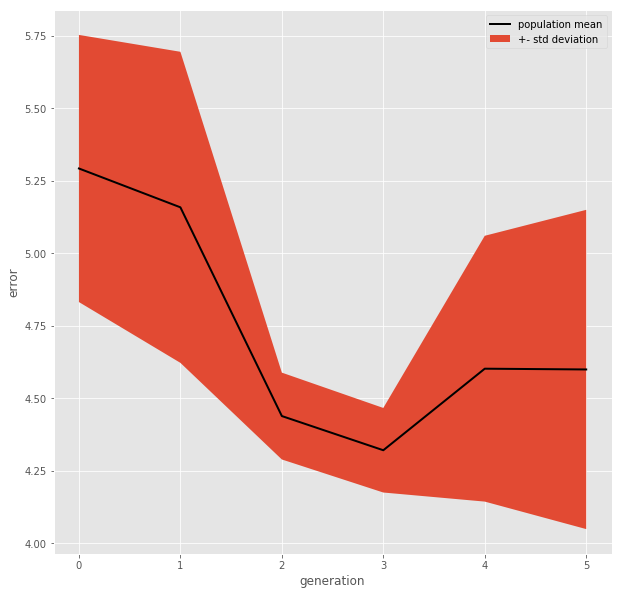

In [16]:
plt.style.use('ggplot')
fig, axes = plt.subplots(figsize=(10, 10), facecolor='white')
val = list(pipe_results.values())[1]
log = val['log']
hof = val['hof_py']
mean = np.array([ np.sum(i) for i in log.select('avg')])
std = np.array([ np.sum(i) for i in log.select('std')])
gen_numbers = [ i for i in range(0,len(log.select('gen'))) ]


print(len(mean),len(std))
minimum = np.array([ np.sqrt(np.mean(np.square(i))) for i in log.select('min')])

historiess = [sum(h.dtc.scores.values()) for h in pipe_results[k]['history'].genealogy_history.values() ]
min_value = np.min(historiess)    


stdminus = mean - std
stdplus = mean + std
print


axes.plot(
    gen_numbers,
    mean,
    color='black',
    linewidth=2,
    label='population mean')



axes.fill_between(gen_numbers, stdminus, stdplus,label='+- std deviation')
plt.xlabel('generation')
plt.ylabel('error')


plt.legend()

## New insights:
My method for calculating population mean was bad.
## My use of BluePyOpt was bad, in that it used ne elite =0 
I suspect that grid search is going to find dominated optima. Therefore I should use an optimisation technique that also favors global optima.



4.3226437302864404 3.35417841635
4.12943439258374 3.35417841635
3.8038539556713955 3.35417841635
3.8038539556713955 3.35417841635
5.14330082773465 4.08006871069
4.348633241118298 4.08006871069
4.292748516381854 4.08006871069
4.292748516381854 4.08006871069
5.14330082773465 4.08006871069
4.348633241118298 4.08006871069
4.292748516381854 4.08006871069
4.292748516381854 4.08006871069


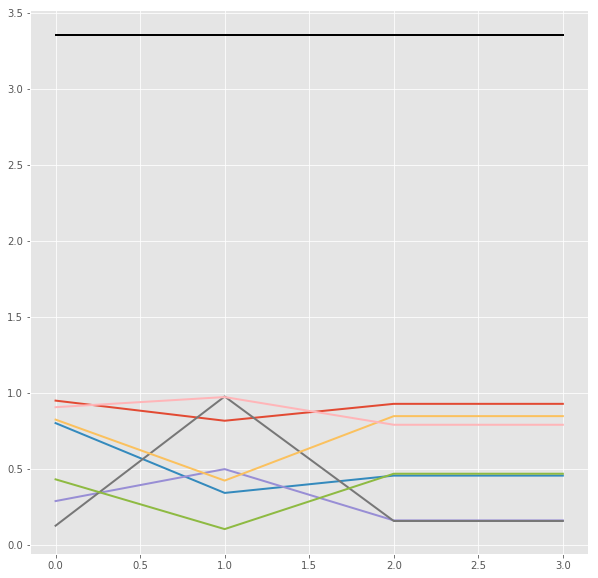

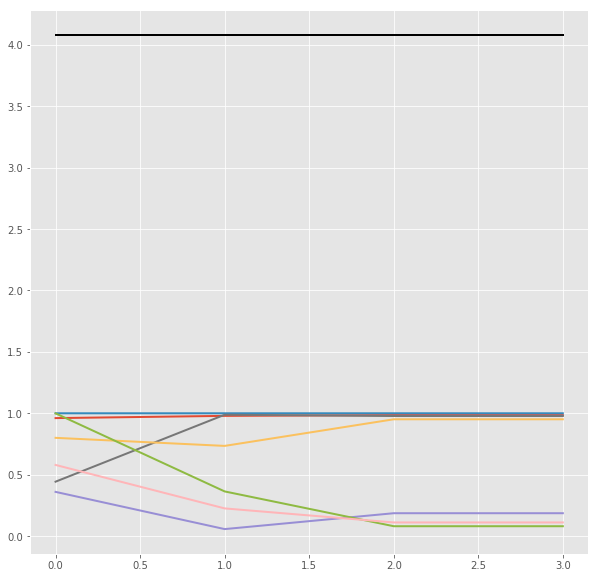

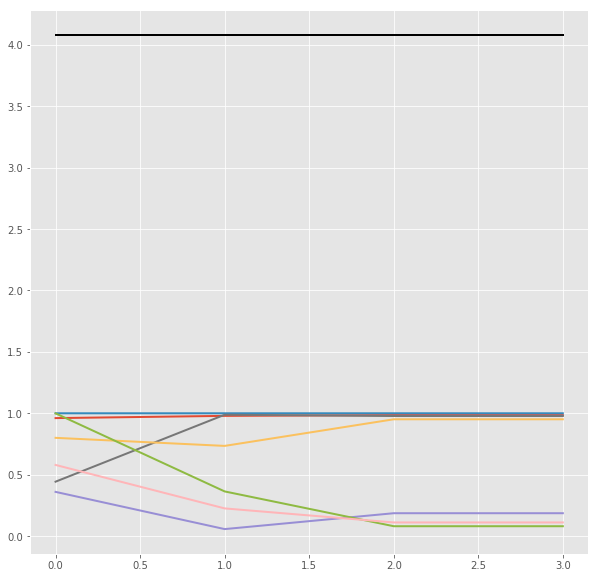

In [17]:
best_line = None
for k in pipe_results.keys():
    plt.style.use('ggplot')
    fig, axes = plt.subplots(figsize=(10, 10), facecolor='white')
    val = pipe_results[k]
    log = val['log']
    gen_numbers = [ i for i in range(0,len(log.select('gen'))) ]
    historiess = [sum(h.dtc.scores.values()) for h in pipe_results[k]['history'].genealogy_history.values() ]
    min_value = np.min(historiess)  
    

    axes.plot([i for i in range(0,len(pipe_results[k]['componentsh'] )) ],
        pipe_results[k]['componentsh'] ,
        linewidth=2,
        label='population average')
    

    axes.plot(
        [i for i in range(0,len(pipe_results[k]['componentsh'] )) ],
        [min_value for i in range(0,len(pipe_results[k]['componentsh'] ))  ],
        color='black',
        linewidth=2,
        label='population average')
    
    for i in pipe_results[k]['componentsh']:
        print(sum(i),min_value)
        if sum(i) == min_value:
            print('yes')

    




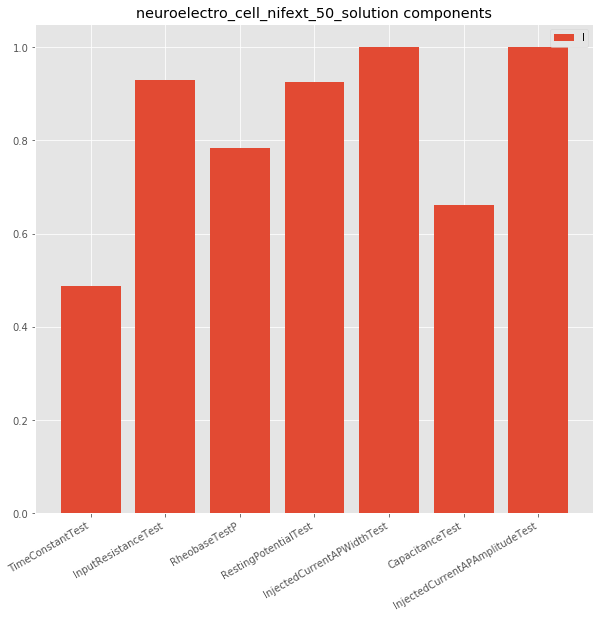

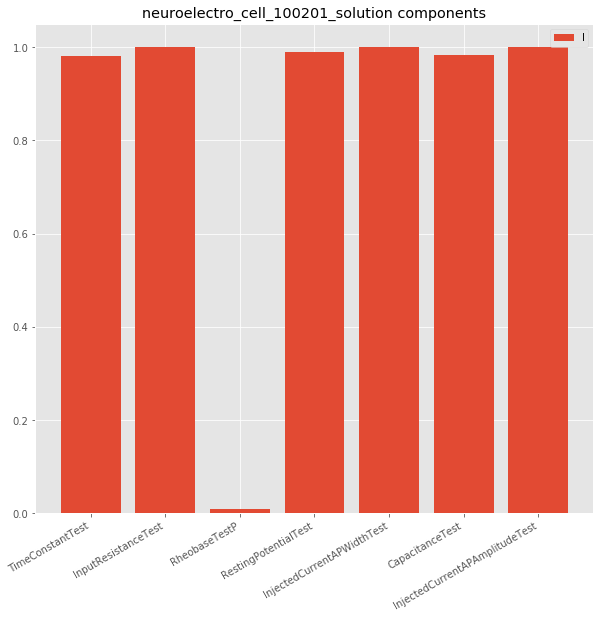

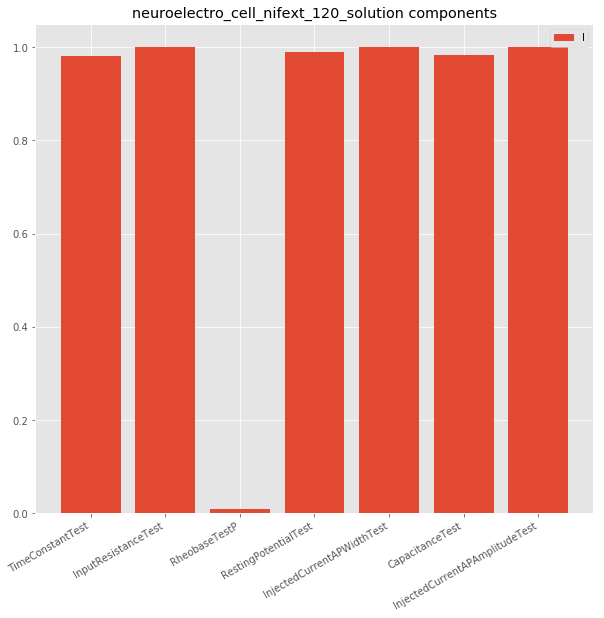

In [18]:
##
# Rational, want to find out how dominated the best solution is:
##
best_line = None
for k in pipe_results.keys():
    plt.style.use('ggplot')
    fig, axes = plt.subplots(figsize=(10, 10), facecolor='white')
    val = pipe_results[k]
    log = val['log']
    
    historiest = [(sum(h.dtc.scores.values()),h.dtc) for h in pipe_results[k]['history'].genealogy_history.values() ]
    ranked = sorted(historiest, key=lambda w: w[0],reverse = True) 
    pipe_results[k]['abs_min'] = ranked[0][1]
    min_value = ranked[0][0]
    
    axis = [ i for i in range(0,len(ranked[0][1].scores.values())) ]
    plt.bar(axis,list(ranked[0][1].scores.values()),tick_label=list(ranked[0][1].scores.keys()))
    fig.autofmt_xdate()
    plt.title('neuroelectro_cell_{0}_{1}'.format(str(k),str('solution components')))
    plt.legend('left')


            
            
            

In [19]:
for index, val in enumerate(pipe_results.values()):

    print(val['gen_vs_hof'])

[<deap.tools.support.HallOfFame object at 0x7f503fb14d30>, [0.0012735391300182997, -62.016987962848397, -3.0942997938551452e-09, 0.0019902204167996044, 34.453871940548012, 0.15823100485111741, -69.280944468238687, 0.00010890541935634914, -31.971450847770328, -59.847050084832233], [0.00074773354200908832, -65.650223927817521, -2.5477595926159384e-09, 0.41205881420255608, 30.698574368407595, 0.11683189678093264, -53.524838178101788, 0.00010112909150950299, -38.157244365025839, -59.909188757860804], [0.0012504027456944761, -62.016987962848397, -3.0942997938551452e-09, 0.11334319782797163, 34.888958356629267, 0.15823100485111741, -69.539783154949916, 0.00010825182385888079, -48.898674927566773, -59.934862827067072], [0.0012504027456944761, -62.016987962848397, -3.0942997938551452e-09, 0.11334319782797163, 34.888958356629267, 0.15823100485111741, -69.539783154949916, 0.00010825182385888079, -48.898674927566773, -59.934862827067072], [0.0012504027456944761, -62.016987962848397, -3.0942997938

# Comment on plot
The plot shows the mean error value of the population as the GA evolves it's population. The red interval at any instant is the standard deviation of the error. The fact that the mean GA error is able to have a net upwards trajectory, after experiencing a temporary downwards trajectory, demonstrates that the GA retains a drive to explore, and is resiliant against being stuck in a local minima. Also in the above plot population variance in error stays remarkably constant, in this way BluePyOpts selection criteria SELIBEA contrasts with DEAPs native selection strategy NSGA2

# Comment on plot
There is good agreement between traces produced by the best candidate found by Genetic Algorithm, and exhaustive grid search.

# Quantize distance between minimimum error and maximum error.
This step will allow the GA's performance to be located within or below the range of error found by grid search.


In [20]:
print(maxi)
print(mini)
print(miniga)
quantize_distance = list(np.linspace(mini,maxi,10))

# check that the nsga error is in the bottom 1/5th of the entire error range.
print('Report: ')
print("Success" if bool(miniga < quantize_distance[0]) else "Failure")
print("The nsga error %f is in the bottom 1/5th of the entire error range" % miniga)
print("Minimum = %f; 20th percentile = %f; Maximum = %f" % (mini,quantize_distance[0],maxi))

NameError: name 'maxi' is not defined

The code below reports on the differences between between attributes of best models found via grid versus attributes of best models found via GA search:


In [ ]:
import pandas as pd

from neuronunit.optimization import evaluate_as_module as eam
NSGAO = NSGA(0.85)
NSGAO.setnparams(nparams=nparams,provided_keys=provided_keys)
#td = eam.get_trans_dict(NSGAO.subset)
#print(td)
td = { v:k for k,v in enumerate(td) }
from neuronunit.optimization import model_parameters as modelp
mp = modelp.model_params
#minimaga = pareto_dtc[0]
for k,v in minimagr_dtc.attrs.items():
    #hvgrid = np.linspace(np.min(mp[k]),np.max(mp[k]),10)
    dimension_length = np.max(mp[k]) - np.min(mp[k])
    solution_distance_in_1D = np.abs(float(hof[0][td[k]]))-np.abs(float(v))
        
    #solution_distance_in_1D = np.abs(float(minimaga.attrs[k]))-np.abs(float(v))
    relative_distance = dimension_length/solution_distance_in_1D
    print('the difference between brute force candidates model parameters and the GA\'s model parameters:')
    print(float(hof[0][td[k]])-float(v),hof[0][td[k]],v,k)
    print('the relative distance scaled by the length of the parameter dimension of interest:')
    print(relative_distance)

    
    

In [ ]:

print('the difference between the bf error and the GA\'s error:')
print('grid search:')
from numpy import square, mean, sqrt
rmsg = sqrt(mean(square(list(minimagr_dtc.scores.values()))))
print(rmsg)
print('ga:')
rmsga = sqrt(mean(square(list(dtc_pop[0].scores.values()))))
print(rmsga)
print('Hall of Fame front')
print(sqrt(mean(square(list(hof[0].fitness.values)))))
print(miniga)


If any time is left over, may as well compute a more accurate grid, to better quantify GA performance in the future.

In [ ]:
from neuronunit.optimization import get_neab
#fi_basket = {'nlex_id':'NLXCELL:100201'}
neuron = {'nlex_id': 'nifext_50'} 

error_criterion, inh_observations = get_neab.get_neuron_criteria(fi_basket)
print(error_criterion)

from bluepyopt.deapext.optimisations import DEAPOptimisation

DO = DEAPOptimisation(error_criterion=error_criterion)
DO.setnparams(nparams = nparams, provided_keys = provided_keys)
pop, hof, log, history, td, gen_vs_hof = DO.run(offspring_size = MU, max_ngen = NGEN, cp_frequency=4,cp_filename='checkpointedGA.p')
with open('ga_dump.p','wb') as f:
   pickle.dump([pop, log, history, hof, td],f)

In [ ]:
# Layer V pyramidal cell
